# Refactored notebook for modelling

## imports

In [170]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import warnings
import re

from NHS_PROMs.load_data import load_proms, structure_name
from NHS_PROMs.preprocess import filter_in_range, filter_in_labels, method_delta
from NHS_PROMs.utils import downcast, map_labels
from NHS_PROMs.data_dictionary import meta_dict

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn import set_config
set_config(display='diagram')

pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows

#from imblearn.over_sampling import SMOTENC

SEED = 888


## load data
General approach is not DRY for the sake of availability of having knee and hip df's always at hand, but also keep it readable (script-wise).

In [171]:
# load data + rename columns with structired name
# df_knee_raw = load_proms(part="knee").apply(downcast).rename(structure_name, axis=1)
df_hip_raw = load_proms(part="hip").apply(downcast).rename(structure_name, axis=1)

# get meta data for each
full_meta = {t + k: v for k, v in meta_dict.items() for t in ["t0_", "t1_"]}
hip_meta = {k: v for k, v in full_meta.items() if k in df_hip_raw.columns}

df_hip_raw.sample(3)

,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,t0_stroke,...,t0_ohs_score,t1_ohs_pain,t1_ohs_sudden_pain,t1_ohs_night_pain,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score,t1_ohs_predicted
23800,RL1,Hip Replacement,0,2017/18,70 to 79,2.0,1,0,3,2,2,2,9,1,9,...,6.0,3,4,4,4,3,4,4,4,4,4,4,4,46.0,35.78
9498,RAS,Hip Replacement,0,2019/20,80 to 89,2.0,2,0,2,2,2,1,1,1,9,...,18.0,4,4,4,4,4,4,3,4,4,3,4,3,45.0,34.49
10492,NV323,Hip Replacement,0,2016/17,50 to 59,1.0,2,0,3,2,1,2,9,1,9,...,23.0,3,3,4,4,4,4,4,4,4,4,4,4,46.0,42.16


## basic cleaning

In [172]:
endings = (
    "code",
    "procedure",
    "revision_flag",
    "assisted_by",
    "profile",
    "predicted",
)
cols2drop = [c for c in df_hip_raw.columns if c.endswith(endings)]

In [173]:
%%time
df_hip_clean = (
    df_hip_raw.apply(lambda s: filter_in_range(s, **hip_meta[s.name]))
    .apply(lambda s: filter_in_labels(s, **hip_meta[s.name]))
    .apply(lambda s: map_labels(s, **hip_meta[s.name]))
    .query("t0_revision_flag == 'no revision'")
    .drop(columns=cols2drop)
    #     .replace("missing", np.nan)
)

df_hip_clean.sample(3)

CPU times: user 802 ms, sys: 117 ms, total: 918 ms
Wall time: 1 s


,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,t0_stroke,t0_circulation,t0_lung_disease,t0_diabetes,t0_kidney_disease,...,t0_ohs_work,t0_ohs_score,t1_ohs_pain,t1_ohs_sudden_pain,t1_ohs_night_pain,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score
11406,April 2017 - April 2018,70 to 79,female,no,1 to 5 years,no,alone,yes,missing,yes,missing,missing,missing,missing,missing,...,all of the time,9.0,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,48.0
20391,April 2016 - April 2017,70 to 79,female,no,1 to 5 years,no,alone,missing,missing,yes,missing,missing,missing,missing,missing,...,"often, not just at first",20.0,rarely/never,rarely/never,"often, not just at first","often, not just at first","often, not just at first","often, not just at first",rarely/never,rarely/never,most of the time,rarely/never,rarely/never,"often, not just at first",35.0
2001,April 2018 - April 2019,NaN,NaN,no,1 to 5 years,no,alone,yes,missing,yes,missing,missing,missing,missing,missing,...,most of the time,14.0,"often, not just at first",missing,missing,sometimes or just at first,missing,missing,missing,missing,missing,missing,missing,missing,NaN


## split data

In [174]:
# split train + test set
# df_knee_seen = df_knee_clean.query("t0_year != '2019/20'")
# df_knee_unseen = df_knee_clean.query("t0_year == '2019/20'")

df_hip = df_hip_clean.query("t0_year != '2019/20'")
df_hip_unseen = df_hip_clean.query("t0_year == '2019/20'")

df_hip.sample(3)

,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,t0_stroke,t0_circulation,t0_lung_disease,t0_diabetes,t0_kidney_disease,...,t0_ohs_work,t0_ohs_score,t1_ohs_pain,t1_ohs_sudden_pain,t1_ohs_night_pain,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score
26822,April 2017 - April 2018,70 to 79,male,no,1 to 5 years,no,with partner / spouse / family / friends,yes,missing,missing,missing,missing,missing,missing,missing,...,most of the time,15.0,"often, not just at first",most of the time,most of the time,"often, not just at first",most of the time,most of the time,"often, not just at first",rarely/never,most of the time,"often, not just at first","often, not just at first","often, not just at first",21.0
16960,April 2019 - April 2020,80 to 89,female,no,1 to 5 years,no,alone,yes,missing,yes,missing,missing,missing,missing,missing,...,"often, not just at first",19.0,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,48.0
30470,April 2016 - April 2017,80 to 89,male,no,less than 1 year,no,with partner / spouse / family / friends,yes,missing,yes,missing,missing,yes,missing,missing,...,"often, not just at first",21.0,rarely/never,rarely/never,"often, not just at first",rarely/never,rarely/never,sometimes or just at first,sometimes or just at first,rarely/never,sometimes or just at first,"often, not just at first",sometimes or just at first,rarely/never,40.0


In [175]:
#df_hip.info()

## create delta dataframes

In [176]:
# df_org = df_hip_seen.apply(
#     lambda s: map_labels(s, backwards=True, **hip_meta[s.name])
# ).apply(np.asarray)

# # df_knee_delta = method_delta(df_knee_train)
# df_hip_delta = method_delta(df_org)

# # now you could join them again with the original df ...
# # eg: df_hip_train.join(df_hip_delta)
# df_hip_delta.sample(5)

## Make feature set

In [177]:
print(len(df_hip), "original")
print(len(df_hip.dropna()), "after possible total dropna")
(df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10)

139251 original
103346 after possible total dropna


t0_age_band          0.09
t0_gender            0.09
t0_eqvas_score       0.09
t0_eq5d_score        0.06
t1_eqvas_score       0.05
t1_eq5d_score        0.04
t0_ohs_score         0.01
t1_ohs_score         0.01
t0_eq5d_mobility     0.00
t0_eq5d_self_care    0.00
dtype: float64

In [178]:
# remove NaNs from non categorical/ordinal columns (numerical)
print(len(df_hip), "original")
num_cols = df_hip.select_dtypes(exclude="category").columns
df_hip = df_hip.dropna(subset=num_cols)

print(len(df_hip), "after dropna on numerical")
(df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10)

139251 original
113818 after dropna on numerical


t0_age_band           0.09
t0_gender             0.09
t1_ohs_score          0.00
t1_assisted           0.00
t0_eq5d_mobility      0.00
t0_eq5d_self_care     0.00
t0_eq5d_activity      0.00
t0_eq5d_discomfort    0.00
t0_eq5d_anxiety       0.00
t0_eq5d_score         0.00
dtype: float64

In [179]:
#df_hip.info()
df_hip.keys()

Index(['t0_year', 't0_age_band', 't0_gender', 't0_assisted', 't0_symptom_period',
       't0_previous_surgery', 't0_living_arrangements', 't0_disability', 't0_heart_disease',
       't0_high_bp', 't0_stroke', 't0_circulation', 't0_lung_disease', 't0_diabetes',
       't0_kidney_disease', 't0_nervous_system', 't0_liver_disease', 't0_cancer', 't0_depression',
       't0_arthritis', 't0_eq5d_mobility', 't0_eq5d_self_care', 't0_eq5d_activity',
       't0_eq5d_discomfort', 't0_eq5d_anxiety', 't0_eq5d_score', 't1_assisted',
       't1_living_arrangements', 't1_disability', 't1_eq5d_mobility', 't1_eq5d_self_care',
       't1_eq5d_activity', 't1_eq5d_discomfort', 't1_eq5d_anxiety', 't1_satisfaction',
       't1_success', 't1_allergy', 't1_bleeding', 't1_wound', 't1_urine', 't1_further_surgery',
       't1_readmitted', 't1_eq5d_score', 't0_eqvas_score', 't1_eqvas_score', 't0_ohs_pain',
       't0_ohs_sudden_pain', 't0_ohs_night_pain', 't0_ohs_washing', 't0_ohs_transport',
       't0_ohs_dressin

### Construct y variable with arthritis severity categories

Based on the Q-scores, patients can be classified in 4 arthritis severity classes: 

0 - 19 = severe arthritis

20 - 29 = moderate arthritis

30 - 39 = mild-to-moderate arthritis

40 - 48 = satisfactory joint function

In [180]:
df_hip["arthritis_cat_t0"] = pd.cut(df_hip.t0_ohs_score,
                                     bins=[0,19,29,39,48],
       labels=['severe','moderate','mild','satisfactory'])

df_hip["arthritis_3cat_t0"] = pd.cut(df_hip.t0_ohs_score,
                                     bins=[0,19,29,48],
       labels=['severe','moderate','mild-satisfactory'])

In [181]:
(df_hip.arthritis_cat_t0.value_counts() / len(df_hip.arthritis_cat_t0)*100)

severe          60.49
moderate        30.84
mild             8.11
satisfactory     0.49
Name: arthritis_cat_t0, dtype: float64

In [182]:
(df_hip.arthritis_3cat_t0.value_counts() / len(df_hip.arthritis_3cat_t0)*100)

severe               60.49
moderate             30.84
mild-satisfactory     8.60
Name: arthritis_3cat_t0, dtype: float64

In [183]:
df_hip["arthritis_cat_t1"] = pd.cut(df_hip.t1_ohs_score,
                                     bins=[0,19,29,39,48],
       labels=['severe','moderate','mild','satisfactory'])

In [184]:
(df_hip.arthritis_cat_t1.value_counts() / len(df_hip.arthritis_cat_t1)*100)

satisfactory    65.89
mild            22.46
moderate         8.45
severe           3.20
Name: arthritis_cat_t1, dtype: float64

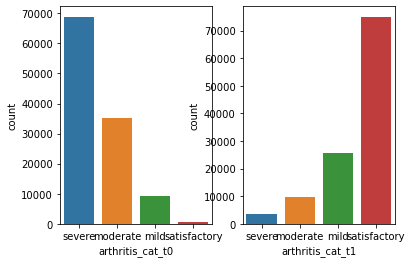

In [185]:
fig, ax = plt.subplots(1, 2)
sns.countplot(x=df_hip.arthritis_cat_t0, ax=ax[0])
sns.countplot(x=df_hip.arthritis_cat_t1, ax=ax[1])
plt.show()

In [186]:
table = pd.crosstab(df_hip["arthritis_cat_t0"], df_hip["arthritis_cat_t1"])
table

arthritis_cat_t1,severe,moderate,mild,satisfactory
arthritis_cat_t0,,,,
severe,3144,7649,17689,40359
moderate,427,1695,6588,26394
mild,48,246,1212,7728
satisfactory,3,10,45,499


### Severity categories imbalanced

At t0 there are, as expected, few patients in the "satisfactory" and the "mild" categories. After operation, the pattern reverses, most patients are in the "satisfactory" and "mild" category and a small number of few remain in the "severe" and "moderate" category.

To avoid an extremely imbalanced Y-variable, we combine the categories "severe" and "mild" at t1 into one category.

In [187]:
df_hip["arthritis_3cat_t1"] = pd.cut(df_hip.t1_ohs_score,
                                     bins=[0,29,39,48],
       labels=['severe-moderate','mild','satisfactory'])

In [188]:
(df_hip.arthritis_3cat_t1.value_counts() / len(df_hip.arthritis_3cat_t1)*100)

satisfactory       65.89
mild               22.46
severe-moderate    11.65
Name: arthritis_3cat_t1, dtype: float64

In [189]:
df_hip = df_hip.dropna().sample(10_000) # dirty drop for the sake of testing pl
#df_hip.info()

In [194]:
# select variables for predictor matrix
X0_cols = ['t0_eq5d_score', 't0_ohs_score', 't0_eqvas_score', 't0_age_band','t0_gender', 
           't0_assisted','t0_symptom_period', 't0_previous_surgery', 't0_living_arrangements',
           't0_disability', 't0_heart_disease', 't0_high_bp', 't0_stroke',
           't0_circulation', 't0_lung_disease', 't0_diabetes', 't0_kidney_disease',
           't0_nervous_system', 't0_liver_disease', 't0_cancer', 't0_depression']


X_cols =['t0_eqvas_score', 't0_age_band', 't0_gender', 't0_assisted',
       't0_symptom_period', 't0_previous_surgery', 't0_living_arrangements',
       't0_disability', 't0_heart_disease', 't0_high_bp', 't0_stroke',
       't0_circulation', 't0_lung_disease', 't0_diabetes', 't0_kidney_disease',
       't0_nervous_system', 't0_liver_disease', 't0_cancer', 't0_depression',
       't0_eq5d_mobility', 't0_eq5d_self_care',
       't0_eq5d_activity', 't0_eq5d_discomfort', 't0_eq5d_anxiety',
       't0_ohs_pain','t0_ohs_sudden_pain', 't0_ohs_night_pain', 
       't0_ohs_washing','t0_ohs_transport', 't0_ohs_dressing', 
       't0_ohs_shopping', 't0_ohs_walking', 't0_ohs_limping', 
       't0_ohs_stairs', 't0_ohs_standing','t0_ohs_work']





In [204]:
#from sklearn.preprocessing import StandardScaler
#from sklearn import preprocessing

#X0 = df_hip[X0_cols]

# define y variable: arthritis in 3 categories: 
#satisfactory, mild, severe-moderate
#y = df_hip["arthritis_3cat_t1"]

# scale the continuous variables
#numeric_columns = list(X0.select_dtypes(exclude = 'category'))
#print(numeric_columns)
#categorical_columns = list(X0.select_dtypes(include = 'category'))
#print(categorical_columns)

#X0_scaled = preprocessing.scale(X0[numeric_columns])
#df_scaled = pd.DataFrame(X0_scaled, columns=X0[numeric_columns].columns)
#df_cat = pd.DataFrame(X0[categorical_columns], columns=X0[categorical_columns].columns)
# get dummies for all categorical variables
#X = pd.get_dummies(X0, prefix_sep='_', drop_first=False)

#X0_s = pd.concat([df_scaled, df_cat], axis=1)
#X0_s.info()


In [214]:
X0 = df_hip[X0_cols]
X = df_hip[X_cols]

y = df_hip["arthritis_3cat_t1"]
X0 = pd.get_dummies(X0, prefix_sep='_', drop_first=False)
X = pd.get_dummies(X, prefix_sep='_', drop_first=False)

In [216]:
#X0.info()

In [58]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 33092 to 8851
Columns: 148 entries, t0_eqvas_score to t0_ohs_work_missing
dtypes: float64(1), uint8(147)
memory usage: 1.6 MB


In [217]:
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X0, y, test_size=0.30, random_state=SEED, stratify=y)

In [218]:
print("The distribution of Outcome in the training set is: \n", y0_train.value_counts(normalize=True))

print("The distribution of Outcome in the test set is: \n", y0_test.value_counts(normalize=True))

The distribution of Outcome in the training set is: 
 satisfactory       0.66
mild               0.22
severe-moderate    0.12
Name: arthritis_3cat_t1, dtype: float64
The distribution of Outcome in the test set is: 
 satisfactory       0.66
mild               0.22
severe-moderate    0.12
Name: arthritis_3cat_t1, dtype: float64


In [219]:
# create x, y
#X = df_hip.filter(regex="t0")
#y = (df_hip["t1_ohs_score"] - df_hip["t0_ohs_score"] <= 8).astype(int) # knee <= 7
#y = df_hip["t1_ohs_score"]

# create train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y)

In [220]:
print("The distribution of Outcome in the training set is: \n", y_train.value_counts(normalize=True))

print("The distribution of Outcome in the test set is: \n", y_test.value_counts(normalize=True))

The distribution of Outcome in the training set is: 
 satisfactory       0.66
mild               0.22
severe-moderate    0.12
Name: arthritis_3cat_t1, dtype: float64
The distribution of Outcome in the test set is: 
 satisfactory       0.66
mild               0.22
severe-moderate    0.12
Name: arthritis_3cat_t1, dtype: float64


In [221]:
observationX0_35 = X0_test.iloc[35, :]
print(observationX0_35)

t0_eq5d_score                0.73
t0_ohs_score                30.00
t0_eqvas_score              90.00
t0_age_band_20 to 29         0.00
t0_age_band_30 to 39         0.00
                            ...  
t0_liver_disease_missing     1.00
t0_cancer_yes                0.00
t0_cancer_missing            1.00
t0_depression_yes            0.00
t0_depression_missing        1.00
Name: 21087, Length: 56, dtype: float64


In [222]:
classY_35 = y_test.iloc[35]
print(classY35)

severe-moderate


In [223]:
observationX35 = X_test.iloc[35, :]
print(observationX35)

t0_eqvas_score                            90.0
t0_age_band_20 to 29                       0.0
t0_age_band_30 to 39                       0.0
t0_age_band_40 to 49                       0.0
t0_age_band_50 to 59                       1.0
                                          ... 
t0_ohs_work_most of the time               0.0
t0_ohs_work_often, not just at first       0.0
t0_ohs_work_sometimes or just at first     1.0
t0_ohs_work_rarely/never                   0.0
t0_ohs_work_missing                        0.0
Name: 21087, Length: 146, dtype: float64


In [224]:
classY35 = y_test.iloc[35]
print(classY35)

satisfactory


### Simple multi class logistic regression

In [225]:
logreg_0model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=10000, random_state=SEED)
logreg_0model.fit(X0_train, y0_train)

LogisticRegression(max_iter=10000, multi_class='ovr', random_state=888)

In [226]:
# define a single row of input data
#observationX3 = X_test.iloc[3, :]
# predict probabilities for classes in X_test
yhat0 = logreg_0model.predict(X0_test)
# predict a multinomial probability distribution
yhatc0 = logreg_0model.predict([X0_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc0)
yhat0_class = logreg_0model.predict_proba([X0_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhat0_class[0])

Predicted Arthritis class: ['satisfactory']
Predicted Probabilities: [0.10718312 0.86735041 0.02546646]


In [227]:
print(classification_report(y0_test, yhat0))

                 precision    recall  f1-score   support

           mild       0.35      0.07      0.11       665
   satisfactory       0.69      0.97      0.81      1979
severe-moderate       0.39      0.08      0.13       356

       accuracy                           0.67      3000
      macro avg       0.48      0.37      0.35      3000
   weighted avg       0.58      0.67      0.57      3000



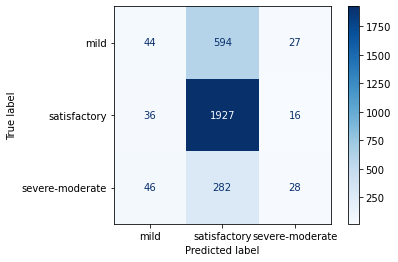

In [228]:
plot_confusion_matrix(logreg_0model, X0_test, y0_test, cmap=plt.cm.Blues) 
plt.show()

### Multi class logistic regression with balanced class weights

In [233]:
logregW_0model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=10000, 
                                   class_weight='balanced', random_state=SEED)
# multi_class = 'ovr' 'multinomial'
logregW_0model.fit(X0_train, y0_train)

LogisticRegression(class_weight='balanced', max_iter=10000, multi_class='ovr',
                   random_state=888)

In [234]:
# define a single row of input data
#observationX3 = X_train.iloc[3, :]
# predict probabilities for classes in X_test
yhatW = logregW_0model.predict(X0_test)
yhatc = logregW_0model.predict([X0_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc)
# predict a multinomial probability distribution
yhatW_class = logregW_0model.predict_proba([X0_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhatW_class[0])

Predicted Arthritis class: ['satisfactory']
Predicted Probabilities: [0.24050623 0.6394013  0.12009247]


In [236]:
print(classification_report(y0_test, yhatW))

                 precision    recall  f1-score   support

           mild       0.29      0.27      0.28       665
   satisfactory       0.78      0.64      0.70      1979
severe-moderate       0.22      0.45      0.30       356

       accuracy                           0.54      3000
      macro avg       0.43      0.46      0.43      3000
   weighted avg       0.60      0.54      0.56      3000



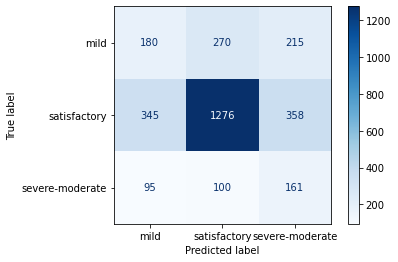

In [237]:
plot_confusion_matrix(logregW_0model, X0_test, y0_test, cmap=plt.cm.Blues) 
plt.show()

### Multiclass logistic regression model with the complete feature set

In [229]:
logreg_model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=10000, random_state=SEED)
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, multi_class='ovr', random_state=888)

In [230]:
# define a single row of input data
#observationX3 = X_test.iloc[3, :]
# predict probabilities for classes in X_test
yhat = logreg_model.predict(X_test)
# predict a multinomial probability distribution
yhatc = logreg_model.predict([X_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc)
yhat_class = logreg_model.predict_proba([X_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhat_class[0])

Predicted Arthritis class: ['satisfactory']
Predicted Probabilities: [0.04806467 0.9254956  0.02643973]


In [231]:
print(classification_report(y_test, yhat))

                 precision    recall  f1-score   support

           mild       0.36      0.10      0.15       665
   satisfactory       0.70      0.96      0.81      1979
severe-moderate       0.36      0.11      0.17       356

       accuracy                           0.67      3000
      macro avg       0.47      0.39      0.38      3000
   weighted avg       0.58      0.67      0.59      3000



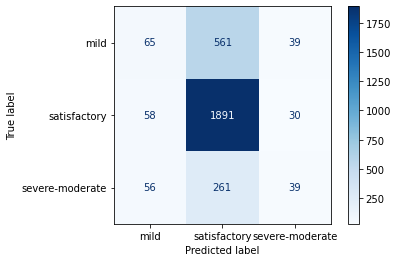

In [232]:
plot_confusion_matrix(logreg_model, X_test, y_test, cmap=plt.cm.Blues) 
plt.show()

### Multi class logistic regression with balanced weights

In [132]:
logregW_model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=10000, 
                                   class_weight='balanced', random_state=SEED)
# multi_class = 'ovr' 'multinomial'
logregW_model.fit(X_train, y_train)


Predicted Probabilities: [0.38234978 0.39374583 0.22390439]


In [159]:
# define a single row of input data
#observationX3 = X_train.iloc[3, :]
# predict probabilities for classes in X_test
yhatW = logregW_model.predict(X_test)
yhatc = logregW_model.predict([X_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc)
# predict a multinomial probability distribution
yhatW_class = logregW_model.predict_proba([X_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhatW_class[0])

Predicted Arthritis class: ['severe-moderate']
Predicted Probabilities: [0.39631231 0.17199329 0.43169441]


In [133]:
print(classification_report(y_test, yhatW))

                 precision    recall  f1-score   support

           mild       0.32      0.30      0.31       678
   satisfactory       0.80      0.67      0.73      1973
severe-moderate       0.24      0.49      0.32       349

       accuracy                           0.57      3000
      macro avg       0.45      0.49      0.45      3000
   weighted avg       0.63      0.57      0.59      3000



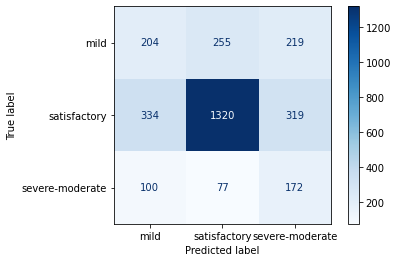

In [134]:
plot_confusion_matrix(logregW_model, X_test, y_test, cmap=plt.cm.Blues) 
plt.show()

### Multi class L1 regularized logistic regression

In [135]:
logregL1_model = LogisticRegression(multi_class='ovr', solver='saga', max_iter=10000, 
                                    penalty='l1', random_state=SEED)

logregL1_model.fit(X_train, y_train)


Predicted Probabilities: [0.25112192 0.68518401 0.06369406]


In [161]:
# define a single row of input data
#observationX3 = X_train.iloc[3, :]
# predict probabilities for classes in X_test
yhatL1 = logregL1_model.predict(X_test)
yhatc = logregL1_model.predict([X_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc)
# predict a multinomial probability distribution
yhatL1_class = logregL1_model.predict_proba([X_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhatL1_class[0])

Predicted Arthritis class: ['satisfactory']
Predicted Probabilities: [0.33319661 0.42046356 0.24633983]


In [150]:
print(classification_report(y_test, yhatL1))

                 precision    recall  f1-score   support

           mild       0.36      0.10      0.16       678
   satisfactory       0.69      0.96      0.80      1973
severe-moderate       0.39      0.09      0.15       349

       accuracy                           0.66      3000
      macro avg       0.48      0.38      0.37      3000
   weighted avg       0.58      0.66      0.58      3000



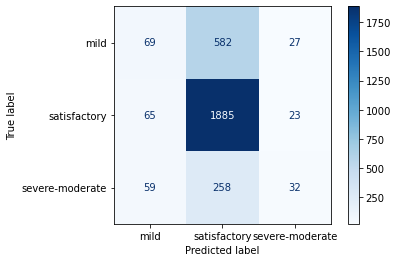

In [137]:
plot_confusion_matrix(logregL1_model, X_test, y_test, cmap=plt.cm.Blues) 
plt.show()

### Multi class L1 regularized logistic regression with balanced weights 

In [138]:
logregWL1_model = LogisticRegression(multi_class='ovr', solver='saga', max_iter=10000, 
                                     penalty='l1', class_weight='balanced', random_state=SEED)

logregWL1_model.fit(X_train, y_train)


Predicted Probabilities: [0.37941591 0.39378338 0.22680071]


In [166]:
# define a single row of input data
#observationX3 = X_train.iloc[3, :]
# predict probabilities for classes in X_test
yhatWL1 = logregWL1_model.predict(X_test)
yhatc = logregWL1_model.predict([X_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc)
# predict a multinomial probability distribution
yhatWL1_class = logregWL1_model.predict_proba([X_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhatWL1_class[0])

Predicted Arthritis class: ['severe-moderate']
Predicted Probabilities: [0.39858655 0.17156185 0.4298516 ]


In [152]:
print(classification_report(y_test, yhatWL1))

                 precision    recall  f1-score   support

           mild       0.32      0.30      0.31       678
   satisfactory       0.80      0.67      0.73      1973
severe-moderate       0.25      0.50      0.33       349

       accuracy                           0.56      3000
      macro avg       0.45      0.49      0.45      3000
   weighted avg       0.62      0.56      0.59      3000



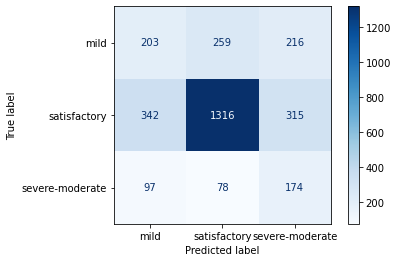

In [153]:
plot_confusion_matrix(logregWL1_model, X_test, y_test, cmap=plt.cm.Blues) 
plt.show()

Feature: 0, Score: -0.00097
Feature: 1, Score: 0.12363
Feature: 2, Score: 0.06720
Feature: 3, Score: -0.03960
Feature: 4, Score: -0.33377
Feature: 5, Score: -0.31785
Feature: 6, Score: -0.03660
Feature: 7, Score: 0.22316
Feature: 8, Score: 0.16541
Feature: 10, Score: -0.01667
Feature: 11, Score: 0.10116
Feature: 13, Score: 0.19680
Feature: 15, Score: -0.11522
Feature: 16, Score: -0.14594
Feature: 17, Score: 0.03154
Feature: 19, Score: 0.06302
Feature: 22, Score: 0.01338
Feature: 23, Score: -0.16029
Feature: 24, Score: -0.06474
Feature: 25, Score: 0.09745
Feature: 27, Score: -0.22310
Feature: 28, Score: 0.53810
Feature: 29, Score: 0.26121
Feature: 32, Score: 0.13094
Feature: 33, Score: -0.04643
Feature: 35, Score: 0.05319
Feature: 36, Score: 0.24288
Feature: 37, Score: -0.15855
Feature: 38, Score: 0.05809
Feature: 40, Score: 0.11271
Feature: 41, Score: -0.02822
Feature: 42, Score: 0.12651
Feature: 43, Score: -0.04205
Feature: 45, Score: 0.07084
Feature: 46, Score: 0.15864
Feature: 47, S

ValueError: shape mismatch: objects cannot be broadcast to a single shape

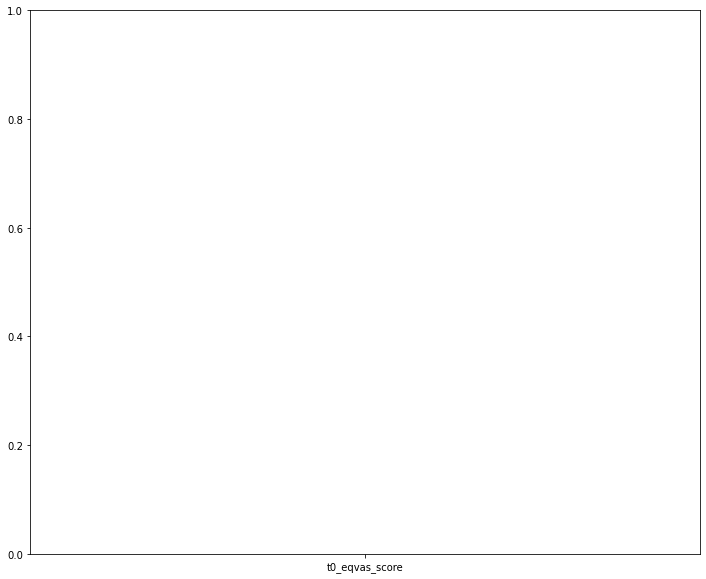

In [154]:
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(logregWL1_model, threshold=1e-5, prefit=True)
feature_idx = model.get_support() 
feature_names = X_train.columns[feature_idx]
#print(feature_names)
importance = logregWL1_model.coef_[0]
for i,v in enumerate(importance):
    if np.abs(v)>=1e-5:
        print('Feature: %0d, Score: %.5f' % (i,v))
sel = importance[np.abs(importance)>=1e-5]
# plot feature importance
plt.figure(figsize=(12, 10))
plt.bar([x for x in feature_names], sel)
plt.xticks(fontsize=10, rotation=70)
plt.ylabel('Feature Importance', fontsize = 14)
plt.show()

### make balanced

In [ ]:
# no correction for imbalance necessary with y = ohs_score (continuous)
#
#print("before:")
#display(y_train.value_counts())

#cat_cols = X_train.dtypes == "category"

#resampler = SMOTENC(categorical_features=cat_cols.values)
#X_train_balanced, y_train_balanced = resampler.fit_resample(X_train, y_train)

#print("after:")
#display(y_train_balanced.value_counts())

## make + train a simple pipeline

In [ ]:
# make the pipeline
ct = make_column_transformer(
    (OneHotEncoder(), make_column_selector(dtype_include="category")),
    (StandardScaler(), make_column_selector(dtype_include="number")),
) 

pl = make_pipeline(ct, KNeighborsClassifier())

# train the pipeline/model
pl.fit(X_train_balanced, y_train_balanced)

## predict + evaluate

In [ ]:
# make prediction
y_hat = pl.predict(X_test.head(500))

# evaluate
print(classification_report(y_test.head(500), y_hat))

## extract feature names pl

In [ ]:
# get the feature names from pipeline
def get_feature_names(sklobj, feature_names=[]):

    if isinstance(sklobj, Pipeline):
        for name, step in sklobj.steps:
            get_feature_names(step, feature_names)
    elif isinstance(sklobj, ColumnTransformer):
        for name, transformer, columns in sklobj.transformers_:
            feature_names += get_feature_names(transformer, columns)
    elif isinstance(sklobj, OneHotEncoder):
        feature_names = sklobj.get_feature_names(feature_names).tolist()
    elif isinstance(sklobj, str):
        if sklobj == "passthrough":
            pass
        elif sklobj == "drop":
            feature_names = []
            
    return feature_names

In [ ]:
get_feature_names(pl)

In [ ]:
# # this is slow ...
# r = permutation_importance(pl, X_train.head(1_000), y_train.head(1_000), n_repeats=2, random_state=0)

# feature_names = get_feature_names(pl)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feature_names[i]:<8}"
#         f"{r.importances_mean[i]:.3f}"
#         f" +/- {r.importances_std[i]:.3f}")